# Intro to Graph Analysis & networkx

Graph analysis is not a new branch of data science, yet is not the usual “go-to” method data scientists apply today. However there are some crazy things graphs can do. Classic use cases range from fraud detection, to recommendations, or social network analysis. A non-classic use case in NLP deals with topic extraction (graph-of-words).

# Fraud Detection Case

You have a database of clients, and would like to know how they are connected to each other. Especially, you know some clients are involved in complex fraud structure, but visualizing the data at an individual level does not bring out evidence of fraud. The fraudsters look like other usual clients.

Working on connections between users can show a lot more information than you had simply by looking at raw data. Specifically, features that would not be considered risky for a usual machine-learning based scoring model (phone number, email address, home address) can become features of risk in a graph based scoring model.

Example: three individuals with the same phone numbers, connected to other individuals with the same email addresses is unusual and potentially risky. The value of the phone number does not give any information in itself (therefore even the best deep learning model would not capture any value out of it), but the fact that individuals are connected through the same values of phone numbers, or email addresses can be synonym of risk.

In [105]:
#---Step 0: Import necessary libraries and render plots inline---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

In [106]:
#---Step 1: Create sample dataframe---

df = pd.DataFrame({'ID':[1,2,3,4,5,6], 
                   'First Name':['Felix', 'Jean', 'James', 'Daphne', 'James', 'Peter'], 
                   'Family Name': ['Revert', 'Durand', 'Wright', 'Hull', 'Conrad', 'Donovan'],
                   'Phone number': ['+33 6 12 34 56 78', '+33 7 00 00 00 00', '+33 6 12 34 56 78', '+33 6 99 99 99 99', '+852 0123 4567', '+852 0123 4567'],
                   'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})

df

,ID,First Name,Family Name,Phone number,Email
0,1,Felix,Revert,+33 6 12 34 56 78,felix.revert@gmail.com
1,2,Jean,Durand,+33 7 00 00 00 00,jean.durand@gmail.com
2,3,James,Wright,+33 6 12 34 56 78,j.custom@gmail.com
3,4,Daphne,Hull,+33 6 99 99 99 99,NaN
4,5,James,Conrad,+852 0123 4567,j.custom@gmail.com
5,6,Peter,Donovan,+852 0123 4567,NaN


In [107]:
#---Step 2: Connect individuals using ID that have the same phone number and email---

column_edge = "Phone number"
column_ID = "ID"

# Select columns and remove NaN values
data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()

In [108]:
# Perform self-merge on ID to create connections between people who have the same phone number
data_to_merge = data_to_merge.merge(data_to_merge[[column_ID, column_edge]], on=column_edge)

# Relabel column names
data_to_merge.columns = ["ID", "Phone number", "ID_2"]

data_to_merge

,ID,Phone number,ID_2
0,1,+33 6 12 34 56 78,1
1,1,+33 6 12 34 56 78,3
2,3,+33 6 12 34 56 78,1
3,3,+33 6 12 34 56 78,3
4,2,+33 7 00 00 00 00,2
5,4,+33 6 99 99 99 99,4
6,5,+852 0123 4567,5
7,5,+852 0123 4567,6
8,6,+852 0123 4567,5
9,6,+852 0123 4567,6


# Cleanup

There are 2 issues here:

-  Individuals are connected with themselves (i.e., ID and ID_2 are the same for each row)
-  When X is connected with Y, then Y is also connected with X and we there have "duplicate" situations

In [109]:
# Remove self connections and only keep connected people who are different
diff_conn = data_to_merge.loc[~(data_to_merge["ID"] == data_to_merge["ID_2"]), :]

diff_conn

,ID,Phone number,ID_2
1,1,+33 6 12 34 56 78,3
2,3,+33 6 12 34 56 78,1
7,5,+852 0123 4567,6
8,6,+852 0123 4567,5


In [112]:
# Avoid counting twice the connections (i.e., person 1 connected to persion 2 and person 2 connected to person 1)

# Create subset of dataframe and generate list of indices for rows to drop (filter out when ID_2 is less than ID)
drop_list = diff_conn.loc[diff_conn["ID_2"] < diff_conn["ID"], :].index.tolist()

# Pass in drop_list to drop() method
diff_conn.drop(drop_list, inplace=True)

diff_conn

C:\Users\cheon\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,ID,Phone number,ID_2
1,1,+33 6 12 34 56 78,3
7,5,+852 0123 4567,6


In [114]:
import networkx as nx

G = nx.from_pandas_edgelist(df=diff_conn, source="ID", target="ID_2", edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=df.ID.tolist())

In [116]:
G.nodes()

NodeView((1, 3, 5, 6, 2, 4))

# Emails

Repeat above process for emails

In [117]:
column_edge = 'Email'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()

data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]

d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

d

,ID,ID_2,Email
3,3,5,j.custom@gmail.com


In [118]:
# Create the connections in the graph
links_attributes = {tuple(row[[column_ID, column_ID+"_2"]]): {column_edge: row[column_edge]} for i,row in d.iterrows()}

G.add_edges_from(links_attributes) # create the connection, without attribute. Check it with G.get_edge_data(3,5)
nx.set_edge_attributes(G=G, values=links_attributes) # adds the attribute. Check it with G.get_edge_data(3,5)

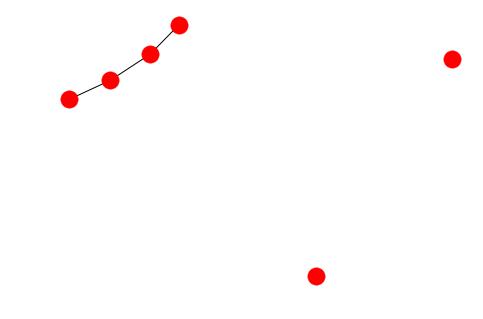

In [119]:
nx.draw(G)

# UNDER CONSTRUCTION